In [1]:
# ====================================================
# Cell 1: Setup & Imports
# ====================================================
import os, glob
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import mlflow



In [2]:
mlflow.autolog()  # Enable MLflow autologging

2025/10/21 09:56:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
# Paths
BASE_PATH = r"D:\hack\impostor_detection\impostor_detection\data\raw\sapimouse\sapimouse"
PROCESSED_PATH = r"D:\hack\impostor_detection\impostor_detection\data\processed"

os.makedirs(PROCESSED_PATH, exist_ok=True)

# Collect user directories
user_dirs = sorted([p for p in os.listdir(BASE_PATH) if p.lower().startswith("user")])
print(f"Found {len(user_dirs)} users")

Found 120 users


In [2]:
# ====================================================
# Cell 2: Utility Functions
# ====================================================
def read_session_csv(path, user_id_from_folder):
    """Read session CSV robustly and return DataFrame with clean columns."""
    try:
        df = pd.read_csv(path, skipinitialspace=True, engine="python")
    except Exception:
        df = pd.read_csv(path, header=None, engine="python")

    if "client" not in df.columns and "client timestamp" not in df.columns:
        # fallback: assume order: ts, button, state, x, y
        df = df.rename(columns={df.columns[0]: "timestamp",
                                df.columns[1]: "button",
                                df.columns[2]: "state",
                                df.columns[3]: "x",
                                df.columns[4]: "y"})
        df["client"] = user_id_from_folder
    else:
        # If client timestamp present, split if needed
        if "client timestamp" in df.columns:
            s = df["client timestamp"].astype(str).str.split(r"\s+", n=1, expand=True)
            if s.shape[1] == 2:
                df["client"] = s[0]
                df["timestamp"] = pd.to_numeric(s[1], errors="coerce")
            else:
                df["client"] = user_id_from_folder
                df["timestamp"] = pd.to_numeric(s[0], errors="coerce")
            df = df.drop(columns=["client timestamp"])
        elif "timestamp" in df.columns:
            df["client"] = user_id_from_folder

    # Ensure numeric coords
    df["x"] = pd.to_numeric(df["x"], errors="coerce")
    df["y"] = pd.to_numeric(df["y"], errors="coerce")

    return df[["client","timestamp","button","state","x","y"]]

def extract_features(df, user_id):
    """Extract dynamic + statistical features for a session."""
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Counts
    total_events = len(df)
    total_moves = (df["state"].str.lower() == "move").sum()
    total_pressed = (df["state"].str.lower() == "pressed").sum()
    total_released = (df["state"].str.lower() == "released").sum()
    total_drags = (df["state"].str.lower() == "drag").sum()
    clicks = total_pressed + total_released

    # Movement dynamics
    dx = df["x"].diff().fillna(0).astype(float)
    dy = df["y"].diff().fillna(0).astype(float)
    dt = df["timestamp"].diff().fillna(1).astype(float)
    dt[dt == 0] = 1.0
    dist = np.sqrt(dx**2 + dy**2)
    speed = dist / dt

    # Base stats
    avg_speed = speed.replace([np.inf, -np.inf], np.nan).fillna(0).mean()
    path_length = dist.sum()
    idle_time = dt[dt > 500].sum()
    total_time = df["timestamp"].iloc[-1] - df["timestamp"].iloc[0] if len(df) > 1 else 0
    idle_fraction = idle_time / total_time if total_time > 0 else 0

    # Auto min/max/mean/std for coords & speed
    stats = {}
    for col, series in {"x": df["x"], "y": df["y"], "speed": speed}.items():
        stats[f"{col}_min"] = series.min()
        stats[f"{col}_max"] = series.max()
        stats[f"{col}_mean"] = series.mean()
        stats[f"{col}_std"] = series.std()

    return {
        "user_id": user_id,
        "n_events": total_events,
        "total_moves": total_moves,
        "clicks": clicks,
        "total_drags": total_drags,
        "avg_speed_px_per_ms": avg_speed,
        "path_length_px": path_length,
        "idle_fraction": idle_fraction,
        **stats
    }


In [3]:
# ====================================================
# Cell 3: Build Feature Tables
# ====================================================
def build_feature_table(session_list, label="1min"):
    rows = []
    for user, path in tqdm(session_list, desc=f"{label} sessions"):
        raw = read_session_csv(path, user)
        feats = extract_features(raw, user)
        feats["session_file"] = os.path.basename(path)
        rows.append(feats)
    return pd.DataFrame(rows)

# Collect files
all_1min, all_3min = [], []
for user in user_dirs:
    user_folder = os.path.join(BASE_PATH, user)
    for fpath in glob.glob(os.path.join(user_folder, "*.csv")):
        if "1min" in fpath.lower():
            all_1min.append((user, fpath))
        elif "3min" in fpath.lower():
            all_3min.append((user, fpath))

df_1min = build_feature_table(all_1min, "1min")
df_3min = build_feature_table(all_3min, "3min")

print("Shapes:", df_1min.shape, df_3min.shape)
display(df_1min.head())


3min sessions: 100%|██████████| 122/122 [00:09<00:00, 12.45it/s]

Shapes: (122, 21) (122, 21)


,user_id,n_events,total_moves,clicks,total_drags,avg_speed_px_per_ms,path_length_px,idle_fraction,x_min,x_max,...,x_std,y_min,y_max,y_mean,y_std,speed_min,speed_max,speed_mean,speed_std,session_file
0,user1,2055,1591,102,362,1.124430,38617.726413,0.000000,128,1908,...,495.830753,69,880,447.439416,196.864942,0.0,12.846753,1.124430,1.890289,session_2020_05_14_1min.csv
1,user10,1760,1333,118,309,1.280491,37444.983442,0.093976,125,1808,...,496.700163,65,837,488.676705,208.288394,0.0,16.271911,1.280491,2.135903,session_2020_05_14_1min.csv
2,user100,2512,2119,168,225,1.293277,54045.074824,0.000000,12,1410,...,329.411795,115,700,407.976911,144.142586,0.0,13.151499,1.293277,1.786868,session_2020_03_31_1min.csv
3,user101,1691,1417,67,207,0.616227,16718.778541,0.260148,53,1258,...,317.500771,67,563,363.341810,108.996939,0.0,12.547687,0.616227,1.140616,session_2020_06_08_1min.csv
4,user102,2236,1742,168,326,1.120358,41592.445983,0.037150,89,1507,...,357.827756,122,729,450.050984,149.782142,0.0,17.804494,1.120358,1.741587,session_2020_03_31_1min.csv


In [4]:
# ====================================================
# Cell 4: Standardization & Saving
# ====================================================
NUMERIC_COLS = [c for c in df_1min.columns if c not in ["user_id","session_file"]]

def save_versioned_csv(df, basename):
    """Save df to processed path with versioning."""
    v = 1
    while True:
        out_path = Path(PROCESSED_PATH) / f"{basename}_v{v}.csv"
        if not out_path.exists():
            break
        v += 1
    df.to_csv(out_path, index=False)
    print(f"Saved {out_path}")

# Standardize and save
scaler = StandardScaler()

if not df_1min.empty:
    df1_scaled = df_1min.copy()
    df1_scaled[NUMERIC_COLS] = scaler.fit_transform(df1_scaled[NUMERIC_COLS].fillna(0))
    save_versioned_csv(df1_scaled, "sapimouse_1min_features")

if not df_3min.empty:
    df3_scaled = df_3min.copy()
    df3_scaled[NUMERIC_COLS] = scaler.fit_transform(df3_scaled[NUMERIC_COLS].fillna(0))
    save_versioned_csv(df3_scaled, "sapimouse_3min_features")


Saved D:\hack\impostor_detection\impostor_detection\data\processed\sapimouse_1min_features_v1.csv
Saved D:\hack\impostor_detection\impostor_detection\data\processed\sapimouse_3min_features_v1.csv


In [4]:
df_1min=pd.read_csv(r"D:\hack\impostor_detection\impostor_detection\data\processed\sapimouse_1min_features_v1.csv")
df_3min=pd.read_csv(r"D:\hack\impostor_detection\impostor_detection\data\processed\sapimouse_3min_features_v1.csv")

In [5]:
# ====================================================
# Cell 5: Sanity Check
# ====================================================
print("1min summary stats:")
display(df_1min.describe().T)

print("3min summary stats:")
display(df_3min.describe().T)


1min summary stats:


,count,mean,std,min,25%,50%,75%,max
n_events,122.0,-2.461601e-16,1.004124,-1.619867,-0.461609,-0.153284,0.183589,3.755971
total_moves,122.0,-6.552136e-17,1.004124,-1.564519,-0.461287,-0.179578,0.134552,4.394504
clicks,122.0,2.629955e-16,1.004124,-2.410763,-0.804263,0.060776,0.774776,2.312622
total_drags,122.0,6.552136e-17,1.004124,-1.604036,-0.557888,-0.118968,0.328203,4.422041
avg_speed_px_per_ms,122.0,2.620854e-16,1.004124,-2.246232,-0.687482,-0.160164,0.513364,3.402798
path_length_px,122.0,-1.815488e-16,1.004124,-1.703958,-0.743516,-0.054479,0.502367,3.033746
idle_fraction,122.0,8.645179e-17,1.004124,-0.710498,-0.647988,-0.416914,0.223190,4.199645
x_min,122.0,9.077438e-17,1.004124,-1.461167,-0.817664,0.032245,0.602898,3.346891
x_max,122.0,-2.529852e-16,1.004124,-2.690137,-0.737158,-0.207208,0.865108,3.154058
x_mean,122.0,6.388332e-16,1.004124,-2.521468,-0.698124,-0.232193,0.708269,3.376987


3min summary stats:


,count,mean,std,min,25%,50%,75%,max
n_events,122.0,-7.826162e-17,1.004124,-1.355672,-0.471881,-0.179558,0.089704,5.902718
total_moves,122.0,1.119323e-16,1.004124,-1.271059,-0.479873,-0.185446,0.117369,6.294494
clicks,122.0,-4.004083e-17,1.004124,-2.251146,-0.640050,0.019260,0.604212,2.715987
total_drags,122.0,1.346828e-16,1.004124,-1.758488,-0.588142,-0.156078,0.231241,4.323956
avg_speed_px_per_ms,122.0,7.280151e-18,1.004124,-2.317678,-0.675240,-0.235949,0.541155,2.944876
path_length_px,122.0,-3.458072e-16,1.004124,-1.695391,-0.732834,-0.168187,0.634546,2.474057
idle_fraction,122.0,1.274026e-17,1.004124,-0.680817,-0.560826,-0.389190,0.184969,4.578051
x_min,122.0,-1.128423e-16,1.004124,-1.123309,-1.013907,-0.175162,0.946204,2.450475
x_max,122.0,2.447951e-16,1.004124,-2.549142,-0.755764,-0.298080,0.966002,3.089411
x_mean,122.0,5.350911e-16,1.004124,-2.597705,-0.708061,-0.264962,0.773943,3.053337


In [6]:
# ====================================================
# Cell X: Train/Validation/Test split by user ranges (val:90-100, test:101-120)
# ====================================================
# This cell assumes `df_1min` and `df_3min` are already built in previous cells.
# We'll create df1_train/df1_val/df1_test and df3_train/df3_val/df3_test
VAL_USER_START = 91
VAL_USER_END = 104
TEST_USER_START = 105
TEST_USER_END = 120
# user ids in the data are strings like 'user100' or numeric; handle both
def normalize_user(u):
    if pd.isna(u):
        return None
    try:
        s = str(u).lower().strip().replace('user', '')
        return int(s)
    except Exception:
        # if it can't be converted, return None
        return None

# helper to split into train/val/test by numeric user ranges
def split_train_val_test_by_user_ranges(df, val_start, val_end, test_start, test_end, user_col='user_id'):
    df = df.copy()
    df['_user_num'] = df[user_col].apply(normalize_user)
    mask_val = df['_user_num'].between(val_start, val_end, inclusive='both')
    mask_test = df['_user_num'].between(test_start, test_end, inclusive='both')
    df_val = df[mask_val].drop(columns=['_user_num']).reset_index(drop=True)
    df_test = df[mask_test].drop(columns=['_user_num']).reset_index(drop=True)
    df_train = df[~(mask_val | mask_test)].drop(columns=['_user_num']).reset_index(drop=True)
    return df_train, df_val, df_test

# Ensure df_1min/df_3min exist; if not, try to load latest processed files
def load_latest_processed(prefix):
    pattern = str(Path(PROCESSED_PATH) / f"{prefix}_v*.csv")
    files = sorted(glob.glob(pattern), key=os.path.getmtime)
    if not files:
        return None
    return pd.read_csv(files[-1])

if 'df_1min' not in globals() or df_1min is None:
    df_1min = load_latest_processed('sapimouse_1min_features')
    if df_1min is None:
        raise RuntimeError('df_1min not found in memory and no processed file available')

if 'df_3min' not in globals() or df_3min is None:
    df_3min = load_latest_processed('sapimouse_3min_features')
    if df_3min is None:
        raise RuntimeError('df_3min not found in memory and no processed file available')

# perform splits (val: 90-100, test: 101-120)
df1_train, df1_val, df1_test = split_train_val_test_by_user_ranges(df_1min, VAL_USER_START, VAL_USER_END, TEST_USER_START, TEST_USER_END, user_col='user_id')
df3_train, df3_val, df3_test = split_train_val_test_by_user_ranges(df_3min, VAL_USER_START, VAL_USER_END, TEST_USER_START, TEST_USER_END, user_col='user_id')

# Print summaries
print('1min - train shape, unique users:', df1_train.shape, df1_train['user_id'].nunique())
print('1min - val shape, unique users:', df1_val.shape, df1_val['user_id'].nunique())
print('1min - test shape, unique users:', df1_test.shape, df1_test['user_id'].nunique())
print('Validation users in 1min val (sample):', sorted(df1_val['user_id'].unique())[:10])
print('Test users in 1min test (sample):', sorted(df1_test['user_id'].unique())[:10])

print('3min - train shape, unique users:', df3_train.shape, df3_train['user_id'].nunique())
print('3min - val shape, unique users:', df3_val.shape, df3_val['user_id'].nunique())
print('3min - test shape, unique users:', df3_test.shape, df3_test['user_id'].nunique())
print('Validation users in 3min val (sample):', sorted(df3_val['user_id'].unique())[:10])
print('Test users in 3min test (sample):', sorted(df3_test['user_id'].unique())[:10])

# quick asserts to ensure val/test splits contain only users in their respective ranges
def assert_users_in_range(df, start, end, user_col='user_id'):
    nums = pd.Series(df[user_col].apply(normalize_user)).dropna().unique().tolist()
    if len(nums) == 0:
        print('Warning: no numeric users found in dataframe')
        return
    bad = [u for u in nums if u < start or u > end]
    if bad:
        raise AssertionError(f'Found users outside expected range in selection: {bad[:5]}...')
    print(f'All {len(nums)} numeric users in selection are within {start}-{end}')

assert_users_in_range(df1_val, VAL_USER_START, VAL_USER_END)
assert_users_in_range(df3_val, VAL_USER_START, VAL_USER_END)
assert_users_in_range(df1_test, TEST_USER_START, TEST_USER_END)
assert_users_in_range(df3_test, TEST_USER_START, TEST_USER_END)

# expose variables to notebook namespace
globals().update({'df1_train': df1_train, 'df1_val': df1_val, 'df1_test': df1_test, 'df3_train': df3_train, 'df3_val': df3_val, 'df3_test': df3_test})
print('Done: created df1_train, df1_val, df1_test, df3_train, df3_val, df3_test')


1min - train shape, unique users: (92, 21) 90
1min - val shape, unique users: (14, 21) 14
1min - test shape, unique users: (16, 21) 16
Validation users in 1min val (sample): ['user100', 'user101', 'user102', 'user103', 'user104', 'user91', 'user92', 'user93', 'user94', 'user95']
Test users in 1min test (sample): ['user105', 'user106', 'user107', 'user108', 'user109', 'user110', 'user111', 'user112', 'user113', 'user114']
3min - train shape, unique users: (92, 21) 90
3min - val shape, unique users: (14, 21) 14
3min - test shape, unique users: (16, 21) 16
Validation users in 3min val (sample): ['user100', 'user101', 'user102', 'user103', 'user104', 'user91', 'user92', 'user93', 'user94', 'user95']
Test users in 3min test (sample): ['user105', 'user106', 'user107', 'user108', 'user109', 'user110', 'user111', 'user112', 'user113', 'user114']
All 14 numeric users in selection are within 91-104
All 14 numeric users in selection are within 91-104
All 16 numeric users in selection are within 1

In [7]:
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools

def _normalize_user_id(u):
    if pd.isna(u): return None
    s = str(u).lower().strip()
    if s.startswith("user"): s = s.replace("user","")
    try:
        return int(s)
    except:
        try: return int(float(s))
        except: return s  # fallback: keep string

def _index_usernums(df, user_col='user_id'):
    usernums = df[user_col].apply(_normalize_user_id).tolist()
    return usernums

def build_all_pairs(df1, df3,
                    user_col='user_id',
                    include_within=False,
                    include_df1_df1=False,
                    include_df3_df3=False,
                    max_total_pairs=None):
    """
    Build PAIRS dataset.

    - By default: returns ONLY CROSS pairs (df1 vs df3), with ALL positives (same user)
      and ALL negatives (different user).
    - include_within: if True and include_df1_df1/include_df3_df3 flags set, also include
      within-df pairs (exhaustive combinations per user) for df1 and/or df3.
    - max_total_pairs: optional global cap (after concatenation); if set, will keep the first
      max_total_pairs rows (no random sampling).
    Returns: X1 (rows from df1), X2 (rows from df3), y (Series: 1 same-user, 0 different-user)
    """

    a = df1.reset_index(drop=True).copy()
    b = df3.reset_index(drop=True).copy()
    nA, nB = len(a), len(b)
    if nA == 0 or nB == 0:
        raise ValueError("df1 and df3 must be non-empty.")

    # get normalized user lists (parallel to rows)
    a_users = _index_usernums(a, user_col)
    b_users = _index_usernums(b, user_col)

    # --- CROSS PAIRS (exhaustive) ---
    # create full index grid -> memory O(nA * nB) for index arrays; user asked for ALL so we do it
    ia = np.repeat(np.arange(nA, dtype=np.int64), nB)
    ib = np.tile(np.arange(nB, dtype=np.int64), nA)

    # vectorized user equality check
    a_users_arr = np.array(a_users, dtype=object)[ia]
    b_users_arr = np.array(b_users, dtype=object)[ib]
    same_mask = (a_users_arr == b_users_arr)

    # positive = same_mask True, negative = False
    pos_idx = np.where(same_mask)[0]
    neg_idx = np.where(~same_mask)[0]

    # build arrays of indices for cross pairs
    ia_cross = ia
    ib_cross = ib
    labels_cross = np.zeros(len(ia_cross), dtype=np.int8)
    labels_cross[pos_idx] = 1

    # If desired, we can split and keep ordering (positives then negatives) or keep this ordering.
    # We'll keep positives first (makes it easier to inspect), then negatives.
    perm_pos = pos_idx
    perm_neg = neg_idx
    order = np.concatenate([perm_pos, perm_neg])

    ia_cross = ia_cross[order]
    ib_cross = ib_cross[order]
    labels_cross = labels_cross[order]

    # create DataFrames for cross pairs (X1 from df1, X2 from df3)
    X1_cross = a.iloc[ia_cross].reset_index(drop=True)
    X2_cross = b.iloc[ib_cross].reset_index(drop=True)
    y_cross = pd.Series(labels_cross, name='same_user').reset_index(drop=True)

    # --- OPTIONAL: include within-df exhaustive pairs ---
    X1_within_parts = []
    X2_within_parts = []
    y_within_parts = []

    if include_within:
        # df1-df1
        if include_df1_df1:
            # for each user, all combinations (i<j) within df1
            user_to_idxs = defaultdict(list)
            for i,u in enumerate(a_users):
                user_to_idxs[u].append(i)
            i_list, j_list, lbls = [], [], []
            for u, idxs in user_to_idxs.items():
                if len(idxs) < 2: continue
                # all ordered pairs? for Siamese you can do combinations (i,j)
                for (i,j) in itertools.combinations(idxs, 2):
                    i_list.append(i); j_list.append(j); lbls.append(1)
                    # also add reversed order if you want both directions:
                    i_list.append(j); j_list.append(i); lbls.append(1)
            if len(i_list):
                X1_within_parts.append(a.iloc[i_list].reset_index(drop=True))
                X2_within_parts.append(a.iloc[j_list].reset_index(drop=True))
                y_within_parts.append(pd.Series(lbls, name='same_user').reset_index(drop=True))

        # df3-df3
        if include_df3_df3:
            user_to_idxs = defaultdict(list)
            for i,u in enumerate(b_users):
                user_to_idxs[u].append(i)
            i_list, j_list, lbls = [], [], []
            for u, idxs in user_to_idxs.items():
                if len(idxs) < 2: continue
                for (i,j) in itertools.combinations(idxs, 2):
                    i_list.append(i); j_list.append(j); lbls.append(1)
                    i_list.append(j); j_list.append(i); lbls.append(1)
            if len(i_list):
                X1_within_parts.append(b.iloc[i_list].reset_index(drop=True))
                X2_within_parts.append(b.iloc[j_list].reset_index(drop=True))
                y_within_parts.append(pd.Series(lbls, name='same_user').reset_index(drop=True))

    # --- CONCATENATE everything ---
    # By default we only include cross pairs. If within parts exist, append them.
    X1_parts = [X1_cross]
    X2_parts = [X2_cross]
    y_parts = [y_cross]

    if X1_within_parts:
        X1_parts.extend(X1_within_parts)
        X2_parts.extend(X2_within_parts)
        y_parts.extend(y_within_parts)

    X1_final = pd.concat(X1_parts, ignore_index=True, sort=False)
    X2_final = pd.concat(X2_parts, ignore_index=True, sort=False)
    y_final = pd.concat(y_parts, ignore_index=True, sort=False)

    # optional global cap (keeps first rows deterministically)
    if max_total_pairs is not None and len(y_final) > max_total_pairs:
        X1_final = X1_final.iloc[:max_total_pairs].reset_index(drop=True)
        X2_final = X2_final.iloc[:max_total_pairs].reset_index(drop=True)
        y_final = y_final.iloc[:max_total_pairs].reset_index(drop=True)

    return X1_final, X2_final, y_final


In [8]:
# ============================
# Cell Y (FIXED for all cross pairs): create pairwise datasets for Siamese training/testing
# ============================

print('Building train pairwise dataset (all cross pairs)...')
X1_train, X2_train, y_train = build_all_pairs(
    df1_train, df3_train,
    include_within=False,          # only cross pairs
    include_df1_df1=False,
    include_df3_df3=False,
    max_total_pairs=None            # keep all
)

print('Building test pairwise dataset (all cross pairs)...')
X1_test, X2_test, y_test = build_all_pairs(
    df1_test, df3_test,
    include_within=False,
    include_df1_df1=False,
    include_df3_df3=False,
    max_total_pairs=None
)

# Build validation pairwise dataset (using df1_val & df3_val)
print('Building validation pairwise dataset (all cross pairs)...')
X1_val, X2_val, y_val = build_all_pairs(
    df1_val, df3_val,
    include_within=False,
    include_df1_df1=False,
    include_df3_df3=False,
    max_total_pairs=None
)

print('TRAIN pairs:', X1_train.shape, X2_train.shape, 'y:', y_train.shape)
print('TRAIN class balance:', y_train.value_counts().to_dict())
print('VAL pairs:', X1_val.shape, X2_val.shape, 'y:', y_val.shape)
print('VAL class balance:', y_val.value_counts().to_dict())
print('TEST pairs:', X1_test.shape, X2_test.shape, 'y:', y_test.shape)
print('TEST class balance:', y_test.value_counts().to_dict())


Building train pairwise dataset (all cross pairs)...
Building test pairwise dataset (all cross pairs)...
Building validation pairwise dataset (all cross pairs)...
TRAIN pairs: (8464, 21) (8464, 21) y: (8464,)
TRAIN class balance: {0: 8368, 1: 96}
VAL pairs: (196, 21) (196, 21) y: (196,)
VAL class balance: {0: 182, 1: 14}
TEST pairs: (256, 21) (256, 21) y: (256,)
TEST class balance: {0: 240, 1: 16}


In [9]:
# =============================================
# Cell: EDA / Data Validation for Siamese inputs
# =============================================
def eda_siamese_inputs(X1, X2, y, df_names=('X1', 'X2', 'y')):
    dfs = [X1, X2, y] if isinstance(y, (pd.DataFrame, pd.Series)) else [X1, X2, y]
    
    for df, name in zip(dfs, df_names):
        print(f"\n=== EDA for {name} ===")
        # Basic info
        if isinstance(df, pd.Series):
            print("Type: Series")
            print(f"Dtype: {df.dtype}")
            print(f"Length: {len(df)}")
        else:
            print("Type: DataFrame")
            print(df.info())
        
        # Null / NaN counts per column
        if isinstance(df, pd.DataFrame):
            null_counts = df.isna().sum()
            print("\nNull/NaN counts per column:")
            print(null_counts[null_counts > 0] if null_counts.sum() > 0 else "No nulls found")
        else:  # Series
            null_count = df.isna().sum()
            print(f"\nNull/NaN count: {null_count}")
        
        # Data type mismatches: check if object columns are actually numeric
        if isinstance(df, pd.DataFrame):
            for col in df.columns:
                if df[col].dtype == 'object':
                    # attempt to convert to numeric
                    converted = pd.to_numeric(df[col], errors='coerce')
                    num_invalid = converted.isna().sum()
                    if num_invalid > 0:
                        print(f"Warning: Column '{col}' has {num_invalid} non-numeric entries")
        elif df.dtype == 'object':
            converted = pd.to_numeric(df, errors='coerce')
            num_invalid = converted.isna().sum()
            if num_invalid > 0:
                print(f"Warning: Series '{name}' has {num_invalid} non-numeric entries")
        
        # Optional: basic descriptive stats
        if isinstance(df, pd.DataFrame):
            print("\nDescriptive statistics:")
            print(df.describe())
        elif isinstance(df, pd.Series) and np.issubdtype(df.dtype, np.number):
            print("\nDescriptive statistics:")
            print(df.describe())

# Usage:
eda_siamese_inputs(X1_train, X2_train, y_train, df_names=('X1_train', 'X2_train', 'y_train'))
# also inspect validation pairs
eda_siamese_inputs(X1_val, X2_val, y_val, df_names=('X1_val', 'X2_val', 'y_val'))
eda_siamese_inputs(X1_test, X2_test, y_test, df_names=('X1_test', 'X2_test', 'y_test'))



=== EDA for X1_train ===
Type: DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8464 entries, 0 to 8463
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              8464 non-null   object 
 1   n_events             8464 non-null   float64
 2   total_moves          8464 non-null   float64
 3   clicks               8464 non-null   float64
 4   total_drags          8464 non-null   float64
 5   avg_speed_px_per_ms  8464 non-null   float64
 6   path_length_px       8464 non-null   float64
 7   idle_fraction        8464 non-null   float64
 8   x_min                8464 non-null   float64
 9   x_max                8464 non-null   float64
 10  x_mean               8464 non-null   float64
 11  x_std                8464 non-null   float64
 12  y_min                8464 non-null   float64
 13  y_max                8464 non-null   float64
 14  y_mean               8464 non-null   float64
 

In [10]:
# Drop non-numeric/object columns
cols_to_drop = ['user_id', 'session_file']

# Ensure validation/train/test pairframes exist
X1_train_numeric = X1_train.drop(columns=cols_to_drop)
X2_train_numeric = X2_train.drop(columns=cols_to_drop)

X1_val_numeric = X1_val.drop(columns=cols_to_drop)
X2_val_numeric = X2_val.drop(columns=cols_to_drop)

X1_test_numeric = X1_test.drop(columns=cols_to_drop)
X2_test_numeric = X2_test.drop(columns=cols_to_drop)


In [11]:
# =========================
# Cell 1: Siamese Network Architecture
# =========================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

# Input feature dimension
input_dim = X1_train_numeric.shape[1]

# Embedding/Encoder
def create_encoder(input_dim, embedding_dim=64):
    inp = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Dense(embedding_dim, activation=None)(x)
    # L2 normalization for embedding
    x = Lambda(lambda t: K.l2_normalize(t, axis=1))(x)
    return Model(inp, x, name='encoder')

# Create shared encoder
encoder = create_encoder(input_dim, embedding_dim=64)

# Siamese Inputs
input_a = Input(shape=(input_dim,), name='input_a')
input_b = Input(shape=(input_dim,), name='input_b')

# Encode both inputs
encoded_a = encoder(input_a)
encoded_b = encoder(input_b)

# Merge embeddings: absolute difference + optional element-wise multiplication
merge = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([encoded_a, encoded_b])
# Optional: can also concatenate multiplication: 
# merge = tf.keras.layers.Concatenate()([merge, encoded_a * encoded_b])

# Dense head
x = Dense(64, activation='relu')(merge)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Build Siamese model
siamese_model = Model(inputs=[input_a, input_b], outputs=output)
siamese_model.summary()


2025/10/21 09:57:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/10/21 09:57:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/10/21 09:57:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 64)        │     11,328 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ encoder[0][0],    │
│                     │                   │            │ encoder[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,537 (68.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        loss_pos = -alpha * (1 - y_pred)**gamma * K.log(y_pred)
        loss_neg = -(1 - alpha) * y_pred**gamma * K.log(1 - y_pred)
        return K.mean(y_true * loss_pos + (1 - y_true) * loss_neg)
    return focal_loss_fixed


In [13]:
# =========================
# Cell 2: Compilation with Class-Weighted Loss
# =========================

# Compute class weights manually
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(k): float(v) for k, v in zip(classes, weights)}
print("Class weights:", class_weight_dict)

# Use binary_crossentropy with class weights
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

siamese_model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)


Class weights: {0: 0.505736137667304, 1: 44.083333333333336}


In [14]:
# =========================
# Cell 3: Training with EarlyStopping
# =========================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = siamese_model.fit(
    [X1_train_numeric, X2_train_numeric], y_train,
    validation_data=([X1_val_numeric, X2_val_numeric], y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=2,
)


2025/10/21 09:57:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'baf32f418ed64c77a063d83c12f8992f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/10/21 09:57:37 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2025/10/21 09:57:37 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2025/10/21 09:57:37 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2025/10/21 09:57:37 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'


Epoch 1/100


133/133 - 11s - 84ms/step - accuracy: 0.6751 - loss: 0.1665 - val_accuracy: 0.9286 - val_loss: 0.0540 - learning_rate: 1.0000e-03
Epoch 2/100
Epoch 2/100


133/133 - 1s - 9ms/step - accuracy: 0.8918 - loss: 0.0547 - val_accuracy: 0.9286 - val_loss: 0.0301 - learning_rate: 1.0000e-03
Epoch 3/100
Epoch 3/100


133/133 - 1s - 8ms/step - accuracy: 0.9609 - loss: 0.0254 - val_accuracy: 0.9286 - val_loss: 0.0242 - learning_rate: 1.0000e-03
Epoch 4/100
Epoch 4/100


133/133 - 1s - 9ms/step - accuracy: 0.9777 - loss: 0.0176 - val_accuracy: 0.9286 - val_loss: 0.0239 - learning_rate: 1.0000e-03
Epoch 5/100
Epoch 5/100
133/133 - 1s - 7ms/step - accuracy: 0.9835 - loss: 0.0141 - val_accuracy: 0.9286 - val_loss: 0.0250 - learning_rate: 1.0000e-03
Epoch 6/100
133/133 - 1s - 7ms/step - accuracy: 0.9835 - loss: 0.0141 - val_accuracy: 0.9286 - val_loss: 0.0250 - learning_rate: 1.0000e-03
Epoch 6/100
133/133 - 1s - 10ms/step - accuracy: 0.9868 - loss: 0.0105 - val_accuracy: 0.9286 - val_loss: 0.0267 - learning_rate: 1.0000e-03
Epoch 7/100
133/133 - 1s - 10ms/step - accuracy: 0.9868 - loss: 0.0105 - val_accuracy: 0.9286 - val_loss: 0.0267 - learning_rate: 1.0000e-03
Epoch 7/100
133/133 - 1s - 10ms/step - accuracy: 0.9869 - loss: 0.0101 - val_accuracy: 0.9286 - val_loss: 0.0284 - learning_rate: 1.0000e-03
Epoch 8/100
133/133 - 1s - 10ms/step - accuracy: 0.9869 - loss: 0.0101 - val_accuracy: 0.9286 - val_loss: 0.0284 - learning_rate: 1.0000e-03
Epoch 8/100
133/

2025/10/21 09:58:04 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'list'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/10/21 09:58:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 09:58:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 09:58:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/10/21 09:58:04 WARNING mlflow.tensorflow: You are saving a Te

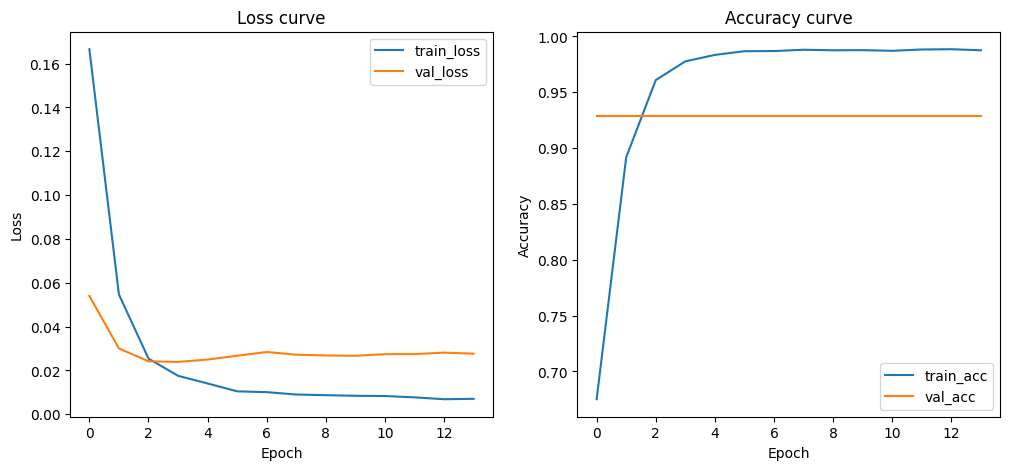

In [15]:
# =========================
# Cell 4: Plot Training Curves
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Confusion Matrix:
 [[240   0]
 [ 16   0]]
Confusion Matrix:
 [[240   0]
 [ 16   0]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9375    1.0000    0.9677       240
           1     0.0000    0.0000    0.0000        16

    accuracy                         0.9375       256
   macro avg     0.4688    0.5000    0.4839       256
weighted avg     0.8789    0.9375    0.9073       256


Classification Report:
               precision    recall  f1-score   support

           0     0.9375    1.0000    0.9677       240
           1     0.0000    0.0000    0.0000        16

    accuracy                         0.9375       256
   macro avg     0.4688    0.5000    0.4839       256
weighted avg     0.8789    0.9375    0.9073       256



d:\hack\impostor_detection\impostor_detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\hack\impostor_detection\impostor_detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\hack\impostor_detection\impostor_detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

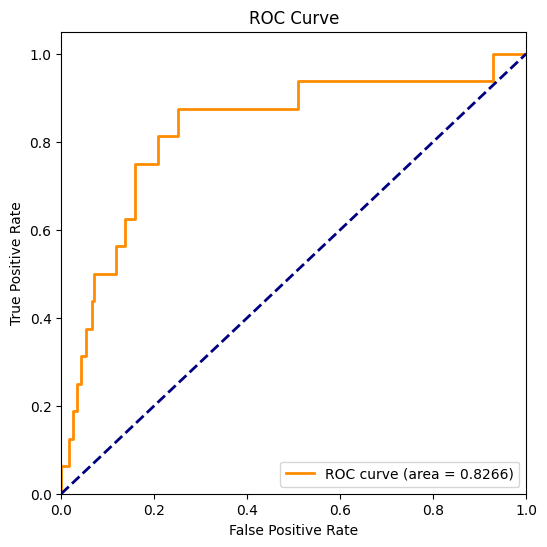

In [16]:
# =========================
# Cell 5: Evaluation Metrics
# =========================
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Predict probabilities
y_pred_prob = siamese_model.predict([X1_test_numeric, X2_test_numeric])
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [36]:
!mlflow ui --host 0.0.0.0 --port 5000


^C
